# Imports


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
import statsmodels.tools 
from sklearn.model_selection import train_test_split

%matplotlib inline
pd.set_option('max_colwidth',99999)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA 

In [ ]:
!pip install factor_analyzer
from factor_analyzer import FactorAnalyzer

In [ ]:
!pip install plotnine

In [ ]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

In [ ]:
new_df=pd.read_csv('index_df.csv')

# Data prep


In [ ]:
#keep complete cases only
full=new_df[['Country Name', 'Country Code', 'Continent', 'Year', 
       'Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX',
       'Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS',
       'pol_gen', 'exl_gen', 'exl_eco', 'exl_geo', 'exl_pol', 'exl_soc',
       'labour_share',
       'suffrage_f', 'domestic_movement', 'slave', 'suffrage', 'v2xeg_eqaccess']].dropna(axis = 0, how = 'any')

In [ ]:
#extract feature columns
features_df=new_df[[ 
       'Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX',
       'Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS',
       'pol_gen', 'exl_gen', 'exl_eco', 'exl_geo', 'exl_pol', 'exl_soc',
       'labour_share',
       'suffrage_f', 'domestic_movement', 'slave', 'suffrage', 'v2xeg_eqaccess']].dropna(axis = 0, how = 'any')

In [ ]:
#standardise variables
scaler = StandardScaler()

scaled_df=features_df.copy()
scaled_df=pd.DataFrame(scaler.fit_transform(scaled_df))
scaled_df.head()

0         1         2   ...        11        12        13
0 -0.487836 -0.292179 -1.740186  ... -1.034540  0.223874 -1.625174
1  0.505710 -1.198256 -0.469459  ... -0.443768  0.223874  0.142144
2 -2.510411 -1.652585 -3.212216  ... -2.967976 -4.697879 -2.251390
3 -0.345901  0.676515  0.631418  ...  0.496097  0.223874  0.986375
4 -0.700738 -1.383803 -0.412842  ...  0.587398  0.223874 -0.664978

[5 rows x 14 columns]

In [ ]:
features_df.shape

(2545, 14)

#FA

Check for intercorrelations:

**Bartlett’s test of sphericity** checks whether or not the correlation is present in between the observed variables. It tests the null hypothesis (H0) that the observed correlation matrix is an Identical matrix - all the diagonal elements as 1 (no correlation is present among the variables). We want to reject this null hypothesis because factor analysis aims at explaining the common variance i.e. the variation due to correlation among the variables.

**Kaiser-Meyer-Olkin (KMO)** measures how suitable the data is for factor analysis. KMO score is always between 0 to 1. The larger the value, the larger the proportions of variance for the data, and the more applicable it is to use dimensionality reduction techniques such as Factor Analysis since it represents the presence of more correlation among the variables. The thumb of rule is that value should be at least more than 0.6. 


In [ ]:
#Bartlett’s test of sphericity 
chi_square_value,p_value=calculate_bartlett_sphericity(scaled_df)
chi_square_value, p_value
#The p-value is zero so the test was statistically significant, there is a sufficient evidence to conclude that correlation is present among the variables with a 95% confidence level, we can apply factor analysis.

(61588.51413679602, 0.0)

In [ ]:
#KMO 
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(scaled_df)
kmo_model
#The data has an overall proportion of variance of 0.86, indicating that the data has enough correlation and dimensionality reduction techniques such as the factor analysis can be applied.


/usr/local/lib/python3.7/dist-packages/factor_analyzer/utils.py:249: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


0.8632173332542321

In [ ]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer()
fa.fit(scaled_df)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([7.30817427e+00, 2.16869632e+00, 1.12357025e+00, 1.03154673e+00,
       7.07189866e-01, 3.84939437e-01, 3.48090824e-01, 3.01397033e-01,
       2.45757830e-01, 1.53261018e-01, 1.18023881e-01, 6.05154176e-02,
       4.88328871e-02, 4.23926580e-06])

## Select number of factors

Standard practice is to choose factors that: 

*    (i) have associated eigenvalues larger than one; 
*   (ii) contribute individually to the explanation of overall variance by more than 10%; and 


*   (iii) contribute
cumulatively to the explanation of the overall variance by more than 60%. 
Source: https://www.oecd.org/sdd/42495745.pdf

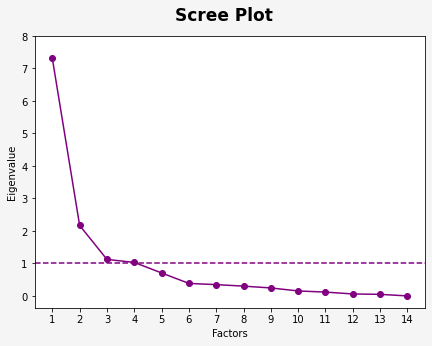

In [ ]:
# Create scree plot using matplotlib to look at eigenvalues
fig, ax = plt.subplots(figsize=(7, 5),facecolor='#F5F5F5')
plt.scatter(range(1,scaled_df.shape[1]+1),ev,color='purple')
plt.plot(range(1,scaled_df.shape[1]+1),ev,color='purple')
plt.axhline(y=1, color='purple', linestyle='dashed')
Ystart, Yend = ax.get_ylim()
ax.text(5.5,Yend+0.8, 'Scree Plot', fontsize=17,fontweight='bold')
plt.xlabel('Factors')
plt.yticks(np.arange(min(ev), max(ev)+1, 1.0))
plt.xticks(np.arange(1, scaled_df.shape[1]+1, 1.0))
plt.ylabel('Eigenvalue')
#plt.grid()
plt.show()

The eigenvalues change less markedly when more than 6 factors are used. Therefore, at most 6 factors would be used. The scree plot shows that the first three factors account for most of the total variability in data. The remaining factors account for much smaller proportion of the variability and are likely unimportant.

In [ ]:
facs = ['Factors' + ' ' + str(i + 1) for i in range(6)]
fa = FactorAnalyzer(n_factors=6,rotation=None) #6 factors are used
fa.fit(scaled_df)
load=pd.DataFrame(fa.loadings_,index=features_df.columns,columns=facs)

In [ ]:
df_variance=pd.DataFrame(fa.get_factor_variance(),index=['Variance','Proportional Var','Cumulative Var'])

In [ ]:
df_variance

0         1         2         3         4         5
Variance          7.154114  2.113002  0.951944  0.523289  0.193012  0.120720
Proportional Var  0.511008  0.150929  0.067996  0.037378  0.013787  0.008623
Cumulative Var    0.511008  0.661937  0.729933  0.767311  0.781097  0.789720

Definitions

*   **Variance (Eigenvalues)**
If you use principal components to extract factors, the variance equals the eigenvalue. You can use the size of the eigenvalue to determine the number of factors. Retain the factors with the largest eigenvalues. For example, using the Kaiser criterion, you use only the factors with eigenvalues that are greater than 1

*  **Percentage/Proportion of Var**
Use the percentage of variance (% Var) to determine the amount of variance that the factors explain. Retain the factors that explain an acceptable level of variance. The acceptable level depends on your application. 


*  **Scree plot**
The scree plot orders the eigenvalues from largest to smallest. The ideal pattern is a steep curve, followed by a bend, and then a straight line. Use the components in the steep curve before the first point that starts the line trend.






(iii) is the most important

*  (i) have associated eigenvalues larger than one **Factor 3 has an eignevalue close to one so I'll still keep it**
*  (ii) contribute individually to the explanation of overall variance by more than 10%; 
*  (iii) contribute cumulatively to the explanation of the overall variance by more than 60% **Factor 1-3 together explain 73% of the variance**

Therefore, we use factor 1-3






**Rotation**

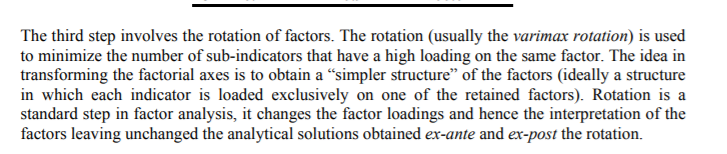

In [ ]:
facs = ['Factors' + ' ' + str(i + 1) for i in range(6)]
fa = FactorAnalyzer(n_factors=6,rotation='varimax') #apply varimax rotation
fa.fit(scaled_df)
load=pd.DataFrame(fa.loadings_,index=features_df.columns,columns=facs)

In [ ]:
load=load[['Factors 1', 'Factors 2', 'Factors 3']]

**Communality** measures the percent of variance in a given variable explained by all the factors jointly and may be interpreted as the reliability of the indicator in the context of the factors being posited.

In [ ]:
arr=fa.get_communalities()
p=load.copy()
p['communalities'] = arr.tolist()

In [ ]:
p

Factors 1  ...  communalities
Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX               0.357890  ...       0.602490
Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS   0.089894  ...       0.737863
pol_gen                                                                          0.434151  ...       0.988413
exl_gen                                                                          0.764850  ...       0.851171
exl_eco                                                                          0.930576  ...       0.942424
exl_geo                                                                          0.935222  ...       0.942084
exl_pol                                                                          0.805425  ...       0.760612
exl_soc                                                                          0.867755  ...       0.930260
labour_share                                                                     0.006071  ...       0.075160
suffrage_f                                                                       0.052205  ...       0.997469
domestic_movement                                                                0.305369  ...       0.763848
slave                                                                            0.285456  ...       0.670808
suffrage                                                                         0.052294  ...       0.997454
v2xeg_eqaccess                                                                   0.560453  ...       0.796024

[14 rows x 4 columns]

The way to interpret communalities:
source:https://online.stat.psu.edu/stat505/lesson/12/12.5
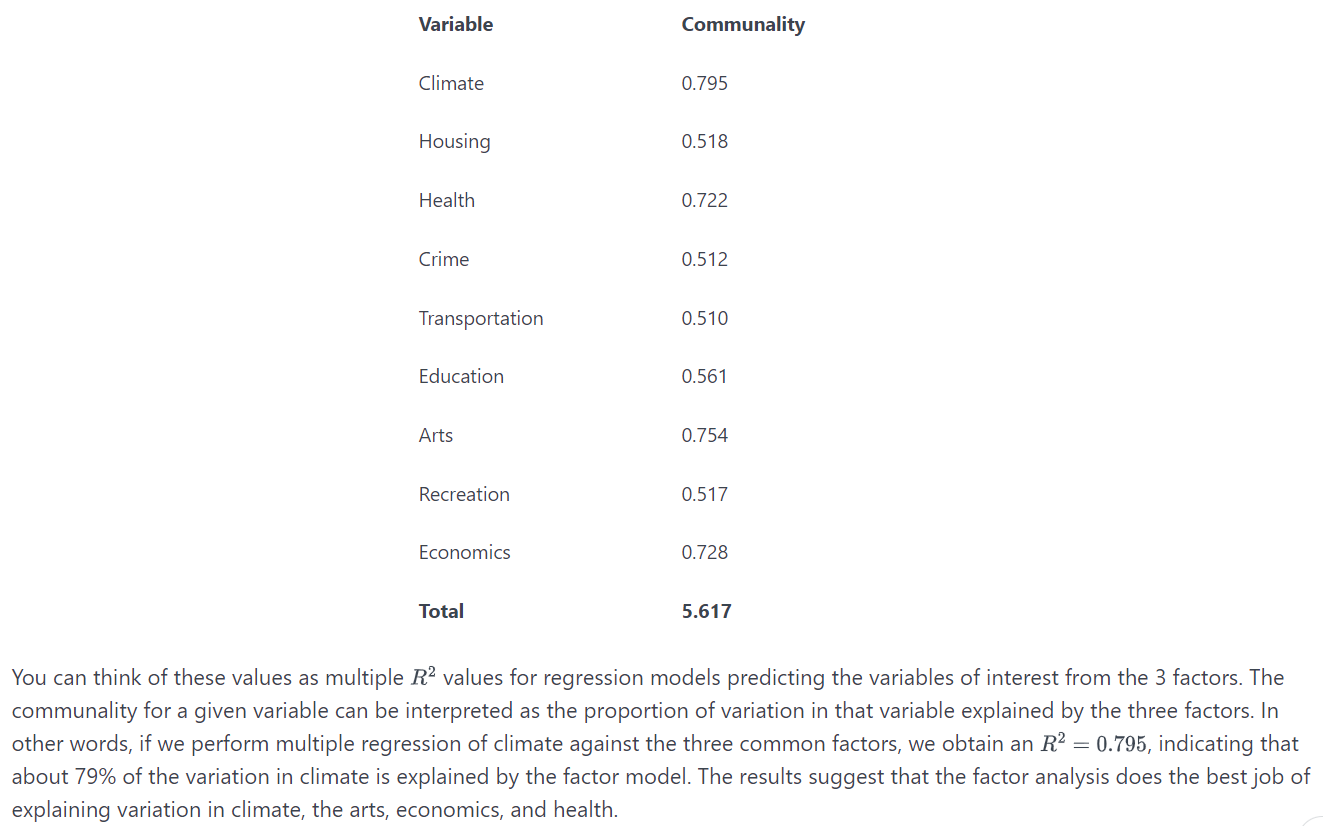

**Interpret communalities**
 The factor model explains almost the entirety of the variance in suffrage/Female suffrage. It does not however explain much of the variance in labour share, this may indicate that less importance is placed on income inequality in the index. I still kept this variable because it is the only variable which captures the time-variant economic conditions that affects equality

recreating this table:

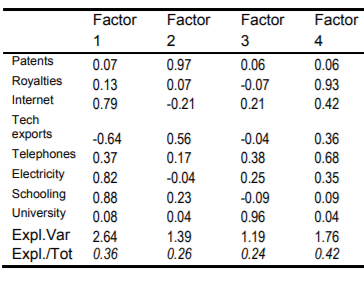

In [ ]:
#calculate the variance explained for each factor
load.sum(axis=0).to_dict()

{'Factors 1': 6.447611152482793,
 'Factors 2': 5.338473135667066,
 'Factors 3': 3.3811614859401367}

In [ ]:
#calculate total variance explained 
load.sum(axis=0).to_frame().sum() 

0    15.167246
dtype: float64

In [ ]:
#append row to the dataframe
new_row={'Factors 1': 6.447611152482793,
 'Factors 2': 5.338473135667066,
 'Factors 3': 3.3811614859401367}
load = load.append(new_row, ignore_index=True)
load

Factors 1  Factors 2  Factors 3
0    0.357890   0.494979   0.202418
1    0.089894   0.212486   0.067291
2    0.434151   0.760328   0.236999
3    0.764850   0.441294   0.121433
4    0.930576   0.214823  -0.015111
5    0.935222   0.163754  -0.024388
6    0.805425   0.249382   0.080017
7    0.867755   0.321335   0.151460
8    0.006071   0.028120  -0.010449
9    0.052205   0.225246   0.968400
10   0.305369   0.727664   0.281337
11   0.285456   0.717030   0.212368
12   0.052294   0.225029   0.968423
13   0.560453   0.557002   0.140963
14   6.447611   5.338473   3.381161

In [ ]:
#calculate the proportion of the explained variance by each factor
#variance explained by each factor divided by total variance explained
new_row={'Factors 1': 6.447611152482793/15.167246,
 'Factors 2': 5.338473135667066/15.167246,
 'Factors 3': 3.3811614859401367/15.167246}

#append row to the dataframe
load = load.append(new_row, ignore_index=True)
load

Factors 1  Factors 2  Factors 3
0    0.357890   0.494979   0.202418
1    0.089894   0.212486   0.067291
2    0.434151   0.760328   0.236999
3    0.764850   0.441294   0.121433
4    0.930576   0.214823  -0.015111
5    0.935222   0.163754  -0.024388
6    0.805425   0.249382   0.080017
7    0.867755   0.321335   0.151460
8    0.006071   0.028120  -0.010449
9    0.052205   0.225246   0.968400
10   0.305369   0.727664   0.281337
11   0.285456   0.717030   0.212368
12   0.052294   0.225029   0.968423
13   0.560453   0.557002   0.140963
14   6.447611   5.338473   3.381161
15   0.425101   0.351974   0.222925

In [ ]:
#add the variable names back to the dataframe
cols=['Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX',
       'Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS',
       'pol_gen', 'exl_gen', 'exl_eco', 'exl_geo', 'exl_pol', 'exl_soc',
       'labour_share', 'suffrage_f', 'domestic_movement', 'slave', 'suffrage',
       'v2xeg_eqaccess','var_explained','prop_var_explained']
load['cols']=cols
load.set_index('cols',inplace=True)

In [ ]:
load 

Factors 1  ...  Factors 3
cols                                                                                       ...           
Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX               0.357890  ...   0.202418
Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS   0.089894  ...   0.067291
pol_gen                                                                          0.434151  ...   0.236999
exl_gen                                                                          0.764850  ...   0.121433
exl_eco                                                                          0.930576  ...  -0.015111
exl_geo                                                                          0.935222  ...  -0.024388
exl_pol                                                                          0.805425  ...   0.080017
exl_soc                                                                          0.867755  ...   0.151460
labour_share                                                                     0.006071  ...  -0.010449
suffrage_f                                                                       0.052205  ...   0.968400
domestic_movement                                                                0.305369  ...   0.281337
slave                                                                            0.285456  ...   0.212368
suffrage                                                                         0.052294  ...   0.968423
v2xeg_eqaccess                                                                   0.560453  ...   0.140963
var_explained                                                                    6.447611  ...   3.381161
prop_var_explained                                                               0.425101  ...   0.222925

[16 rows x 3 columns]

#### Factor 1 explains almost 43% of the variance in the dataset, factor 2 and 3 explain 35% and 22% respectively

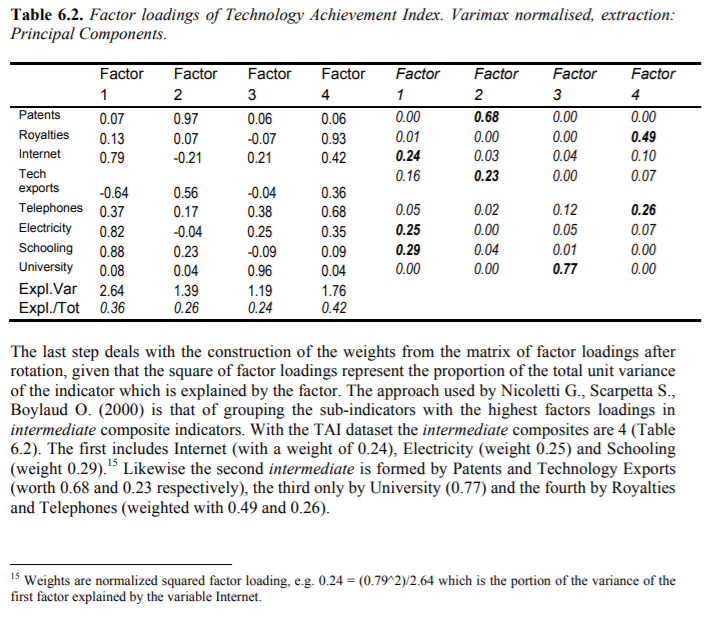

In [ ]:
#compute the weights using the method stated in the footnote
vari_max=load.copy()
var_explained=vari_max[14:15]
vari_max=vari_max[:14]
vari_max['Factors 1']=vari_max['Factors 1']**2/var_explained['Factors 1'][0]
vari_max['Factors 2']=vari_max['Factors 2']**2/var_explained['Factors 2'][0]
vari_max['Factors 3']=vari_max['Factors 3']**2/var_explained['Factors 3'][0]

In [ ]:
vari_max

Factors 1  ...  Factors 3
cols                                                                                       ...           
Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX               0.019866  ...   0.012118
Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS   0.001253  ...   0.001339
pol_gen                                                                          0.029234  ...   0.016612
exl_gen                                                                          0.090731  ...   0.004361
exl_eco                                                                          0.134309  ...   0.000068
exl_geo                                                                          0.135653  ...   0.000176
exl_pol                                                                          0.100612  ...   0.001894
exl_soc                                                                          0.116787  ...   0.006785
labour_share                                                                     0.000006  ...   0.000032
suffrage_f                                                                       0.000423  ...   0.277360
domestic_movement                                                                0.014463  ...   0.023409
slave                                                                            0.012638  ...   0.013339
suffrage                                                                         0.000424  ...   0.277373
v2xeg_eqaccess                                                                   0.048717  ...   0.005877

[14 rows x 3 columns]

Recreating this table:

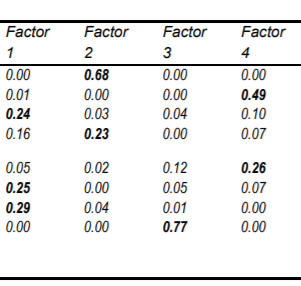

In [ ]:
vari_max.style.highlight_max(color = 'lightgreen', axis = 1)

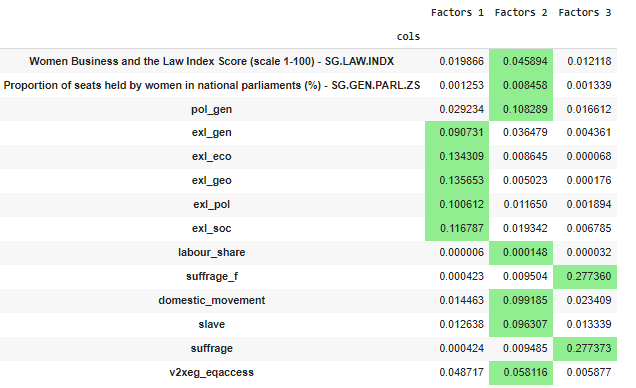

**Interpretation of factor loadings**
- Determine the factor that has the most influence on each variable: Loadings close to -1 or 1 indicate that the factor strongly influences the variable. Loadings close to 0 indicate that the factor has a weak influence on the variable. Some variables may have high loadings on multiple factors.


*   Exclusion by gender(0.09), socialeconomic position(0.13), urban-rural population(0.14), political group(0.10) and social group(0.12) have large positive loadings on factor 1, so this factor describes whether the state discriminates against individuals based on their identity or belonging to a
particular group, i.e. the extent to which public policy actively deny access to services or participation in
governed spaces (spaces that are part of the public space and the government should regulate). This seems to be the bare minimum of what we would expect from a country that has low inequality. 
According to the vdem codebook, these exclusion indicies measure
  *   whether individuals are excluded from positions of
power
  *   whether they enjoy the same level of civil liberties/state’s protection of rights and freedoms
  *   access to public services, state jobs and business opportunities




*  The variables that load heavily on factor 2 relate to the politicoeconomic conditions of the country. Factor 1 focuses on unequal treatment in the public space and the state's capacity to discriminate. Since the private sphere is likely to follow state policy, we can also infer that factor 1 would implicate the potential/possibility of individuals being treated unequally in the private sphere. Whereas, factor 2 describes the actual state of affairs in both the public and private spheres. It looks at things such as do women actually take part in the political decision-making process or are they paid the same amount as men, even if on paper men and women enjoy the same rights and opportunities. And how much power the groups actually wield in reality. Not being denied access to opportunities does not necessarily mean political power is evenly distributed between groups. I would consider it as a step-up in equality compared to what is described by factor 1. In a way, factor 2 describes the representation of groups in political and economic institutions. Variables for factor 2:
  *   the laws and regulations that affect women’s economic opportunity(Mobility, Workplace, Pay, Marriage, Parenthood, Entrepreneurship, Assets, and Pension)
 *   women participation in political institution
 *   how much income the citizen receives in proportion to GDP
 *   the extent to which citizens are able to move freely within a country
  *  freedom from forced labour- unable to quit a job s/he desires to leave — not by reason of economic necessity but rather by reason of employer’s coercion
  *  political equality(equal access index)- whether a certain group of individuals have a dominant hold on political power



*  Factor 3 describes whether the people have the basic political right to vote. This factor is almost like a proxy variable for regime type



*   Together, all three factors explain 73% of the variation in the data.












Following the approach in the paper, the highest factor loading for each indicator is selected as the weighting in each intermediate. For example, the third intermediate is formed by female suffrage and suffrage

**Aggregting the intermediate composites**

In [ ]:
load[15:16]

Factors 1  Factors 2  Factors 3
cols                                               
prop_var_explained   0.425101   0.351974   0.222925

In [ ]:
#multiply the weights to the raw dataframe for each intermediate
#first intermediate	
full['first']=0.090731	*full['exl_gen'] + 0.134309	*full['exl_eco'] + 0.135653*full['exl_geo'] + 0.100612 *full['exl_pol']+ 0.116787*full['exl_soc']
#second intermediate
full['second']=0.045894*full['Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX'] + 0.008458	*full['Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS']+ 0.108289*full['pol_gen'] + 0.000148*full['labour_share']+ 0.099185 *full['domestic_movement']+ 0.096307*full['slave']+ 	0.058116*full['v2xeg_eqaccess']                      	
#third intermediate
full['third']=  0.277360*full['suffrage_f']+ 0.277373*full['suffrage']
#perform aggregation using the prop of variance explained by each factor
full['index']= full['first']*0.425101	 + full['second']*0.351974 + full['third']*0.222925





*  Even though factor 1 explains the majority of the variance(~43%) in the dataset, when we look at the individual indicators, the variable suffrage of factor 3 gives the highest weighting(0.277373*0.222925=0.062). It appears that factor 3 explains more of a distict concept from factor 1 & 2(there are more overlaps in what 1 & 2 describe) - the concept of political right to vote. So whether a country is a democracy or not seems to be a key criteria for equality in the index. 
*  Second highest loading : exl_geo(exclusion by urban-rural population 0.135653*0.425101	=0.058)


* third highest loading : pol_gen(Women political empowerment index 0.108289**0.351974=0.038)






In [ ]:
full.head()

Country Name Country Code  ...     third     index
2                Angola          AGO  ...  0.554733  0.224678
3               Albania          ALB  ...  0.554733  0.410408
5  United Arab Emirates          ARE  ...  0.000000  0.150749
6             Argentina          ARG  ...  0.554733  0.456415
7               Armenia          ARM  ...  0.554733  0.404210

[5 rows x 22 columns]

In [ ]:
full.describe()

Year  ...        index
count  2540.00000  ...  2540.000000
mean   2009.25315  ...     0.385939
std       5.39741  ...     0.084460
min    2000.00000  ...     0.099631
25%    2005.00000  ...     0.334075
50%    2009.00000  ...     0.388624
75%    2014.00000  ...     0.459278
max    2018.00000  ...     0.503131

[8 rows x 19 columns]

In [ ]:
# Assign ranking
full['Rank'] = full['index'].rank(ascending = False)
full = full.sort_values(by = 'Rank').reset_index()
full['index'] =round(full['index']-0.099631,5) # minus the min value so the index starts from zero

In [ ]:
full.head()

level_0 Country Name Country Code  ...     third    index  Rank
0     3848      Denmark          DNK  ...  0.554733  0.40350   1.0
1     3215      Denmark          DNK  ...  0.554733  0.40341   2.0
2     3426      Denmark          DNK  ...  0.554733  0.40341   3.0
3     3637      Denmark          DNK  ...  0.554733  0.40296   4.0
4     2039       Norway          NOR  ...  0.554733  0.40221   5.0

[5 rows x 24 columns]

In [ ]:
final_index=full.rename(columns={'index':'Composite_index'})

In [ ]:
final_index.head(50)

level_0 Country Name Country Code  ...     third  Composite_index  Rank
0      3848      Denmark          DNK  ...  0.554733          0.40350   1.0
1      3215      Denmark          DNK  ...  0.554733          0.40341   2.0
2      3426      Denmark          DNK  ...  0.554733          0.40341   3.0
3      3637      Denmark          DNK  ...  0.554733          0.40296   4.0
4      2039       Norway          NOR  ...  0.554733          0.40221   5.0
5       984       Norway          NOR  ...  0.554733          0.40184   6.0
6      1195       Norway          NOR  ...  0.554733          0.40183   7.0
7      1406       Norway          NOR  ...  0.554733          0.40183   8.0
8       773       Norway          NOR  ...  0.554733          0.40179   9.0
9      1617       Norway          NOR  ...  0.554733          0.40178  10.0
10     1828       Norway          NOR  ...  0.554733          0.40178  11.0
11     3938       Norway          NOR  ...  0.554733          0.40137  12.0
12     3845      Germany          DEU  ...  0.554733          0.40120  13.0
13     3423      Germany          DEU  ...  0.554733          0.40099  14.0
14     3212      Germany          DEU  ...  0.554733          0.40099  15.0
15     2582      Denmark          DNK  ...  0.554733          0.40091  16.0
16     3004      Denmark          DNK  ...  0.554733          0.40087  17.0
17     3634      Germany          DEU  ...  0.554733          0.40082  18.0
18      140       Norway          NOR  ...  0.554733          0.40081  19.0
19     2793      Denmark          DNK  ...  0.554733          0.40080  20.0
20     3727       Norway          NOR  ...  0.554733          0.40079  21.0
21      562       Norway          NOR  ...  0.554733          0.40078  22.0
22     2790      Germany          DEU  ...  0.554733          0.40077  23.0
23     3001      Germany          DEU  ...  0.554733          0.40077  24.0
24      351       Norway          NOR  ...  0.554733          0.40076  25.0
25     2250       Norway          NOR  ...  0.554733          0.40073  26.0
26     2672       Norway          NOR  ...  0.554733          0.40069  27.0
27     2461       Norway          NOR  ...  0.554733          0.40069  28.0
28     2371      Denmark          DNK  ...  0.554733          0.40050  29.0
29     2707       Sweden          SWE  ...  0.554733          0.40048  30.0
30     2160      Denmark          DNK  ...  0.554733          0.40047  31.0
31     1949      Denmark          DNK  ...  0.554733          0.40043  32.0
32     1738      Denmark          DNK  ...  0.554733          0.40043  33.0
33     2368      Germany          DEU  ...  0.554733          0.39996  34.0
34     2579      Germany          DEU  ...  0.554733          0.39996  35.0
35     2157      Germany          DEU  ...  0.554733          0.39996  36.0
36     1946      Germany          DEU  ...  0.554733          0.39996  37.0
37     2496       Sweden          SWE  ...  0.554733          0.39990  38.0
38     3516       Norway          NOR  ...  0.554733          0.39982  39.0
39     3305       Norway          NOR  ...  0.554733          0.39982  40.0
40     2883       Norway          NOR  ...  0.554733          0.39959  41.0
41     3094       Norway          NOR  ...  0.554733          0.39951  42.0
42      894      Denmark          DNK  ...  0.554733          0.39946  43.0
43       50      Denmark          DNK  ...  0.554733          0.39944  44.0
44     1735      Germany          DEU  ...  0.554733          0.39943  45.0
45     1105      Denmark          DNK  ...  0.554733          0.39942  46.0
46     1527      Denmark          DNK  ...  0.554733          0.39942  47.0
47     1524      Germany          DEU  ...  0.554733          0.39942  48.0
48      683      Denmark          DNK  ...  0.554733          0.39942  49.0
49      472      Denmark          DNK  ...  0.554733          0.39942  50.0

[50 rows x 24 columns]

In [ ]:
final_index.tail(50)

level_0          Country Name  ... Composite_index    Rank
2490     1482  United Arab Emirates  ...         0.07962  2491.0
2491     2339               Bahrain  ...         0.07857  2492.0
2492     2550               Bahrain  ...         0.07849  2493.0
2493     1423                 Qatar  ...         0.07784  2494.0
2494     2761               Bahrain  ...         0.07738  2495.0
2495      582                Rwanda  ...         0.07029  2496.0
2496      371                Rwanda  ...         0.06927  2497.0
2497     1271  United Arab Emirates  ...         0.06848  2498.0
2498      160                Rwanda  ...         0.06784  2499.0
2499     1060  United Arab Emirates  ...         0.06746  2500.0
2500     1704            Bangladesh  ...         0.06324  2501.0
2501     3959          Saudi Arabia  ...         0.06104  2502.0
2502     2651            Madagascar  ...         0.06068  2503.0
2503     2440            Madagascar  ...         0.06048  2504.0
2504     3748          Saudi Arabia  ...         0.06026  2505.0
2505     3326          Saudi Arabia  ...         0.05910  2506.0
2506     3537          Saudi Arabia  ...         0.05889  2507.0
2507     3115          Saudi Arabia  ...         0.05857  2508.0
2508     2904          Saudi Arabia  ...         0.05812  2509.0
2509     2229            Madagascar  ...         0.05724  2510.0
2510     2693          Saudi Arabia  ...         0.05366  2511.0
2511     2482          Saudi Arabia  ...         0.05342  2512.0
2512     2271          Saudi Arabia  ...         0.05318  2513.0
2513     1137                 Haiti  ...         0.05305  2514.0
2514      638  United Arab Emirates  ...         0.05237  2515.0
2515      216  United Arab Emirates  ...         0.05177  2516.0
2516      427  United Arab Emirates  ...         0.05177  2517.0
2517        5  United Arab Emirates  ...         0.05112  2518.0
2518     2060          Saudi Arabia  ...         0.05108  2519.0
2519     1849          Saudi Arabia  ...         0.05096  2520.0
2520      849  United Arab Emirates  ...         0.04990  2521.0
2521     1638          Saudi Arabia  ...         0.04761  2522.0
2522     1427          Saudi Arabia  ...         0.04753  2523.0
2523     1216          Saudi Arabia  ...         0.04553  2524.0
2524      528               Liberia  ...         0.04482  2525.0
2525      739               Liberia  ...         0.04482  2526.0
2526     1005          Saudi Arabia  ...         0.03127  2527.0
2527      794          Saudi Arabia  ...         0.02928  2528.0
2528       55               Eritrea  ...         0.02053  2529.0
2529      266               Eritrea  ...         0.01594  2530.0
2530      477               Eritrea  ...         0.00610  2531.0
2531      688               Eritrea  ...         0.00031  2532.0
2532      899               Eritrea  ...         0.00031  2533.0
2533     2165               Eritrea  ...         0.00016  2534.0
2534     1321               Eritrea  ...         0.00016  2535.0
2535     1110               Eritrea  ...         0.00016  2536.0
2536     1532               Eritrea  ...         0.00001  2537.0
2537     1954               Eritrea  ...         0.00001  2538.0
2538     1743               Eritrea  ...         0.00001  2539.0
2539     2376               Eritrea  ...        -0.00000  2540.0

[50 rows x 24 columns]

In [ ]:
#take a look at the correlations
final_index[[
       'Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX',
       'Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS',
       'pol_gen', 'exl_gen', 'exl_eco', 'exl_geo', 'exl_pol', 'exl_soc',
       'labour_share', 'suffrage_f', 'domestic_movement', 'slave', 'suffrage',
       'v2xeg_eqaccess', 'Composite_index', 'Rank']].corr()[14:15] #	exl_soc(exclusion by socialeconomic position) 0.905863	exl_gen(exclusion by gender)	0.889771 pol_gen(political by gender) 0.846554

Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX  ...      Rank
Composite_index                                                            0.667538  ... -0.969334

[1 rows x 16 columns]

### Some visualisations

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


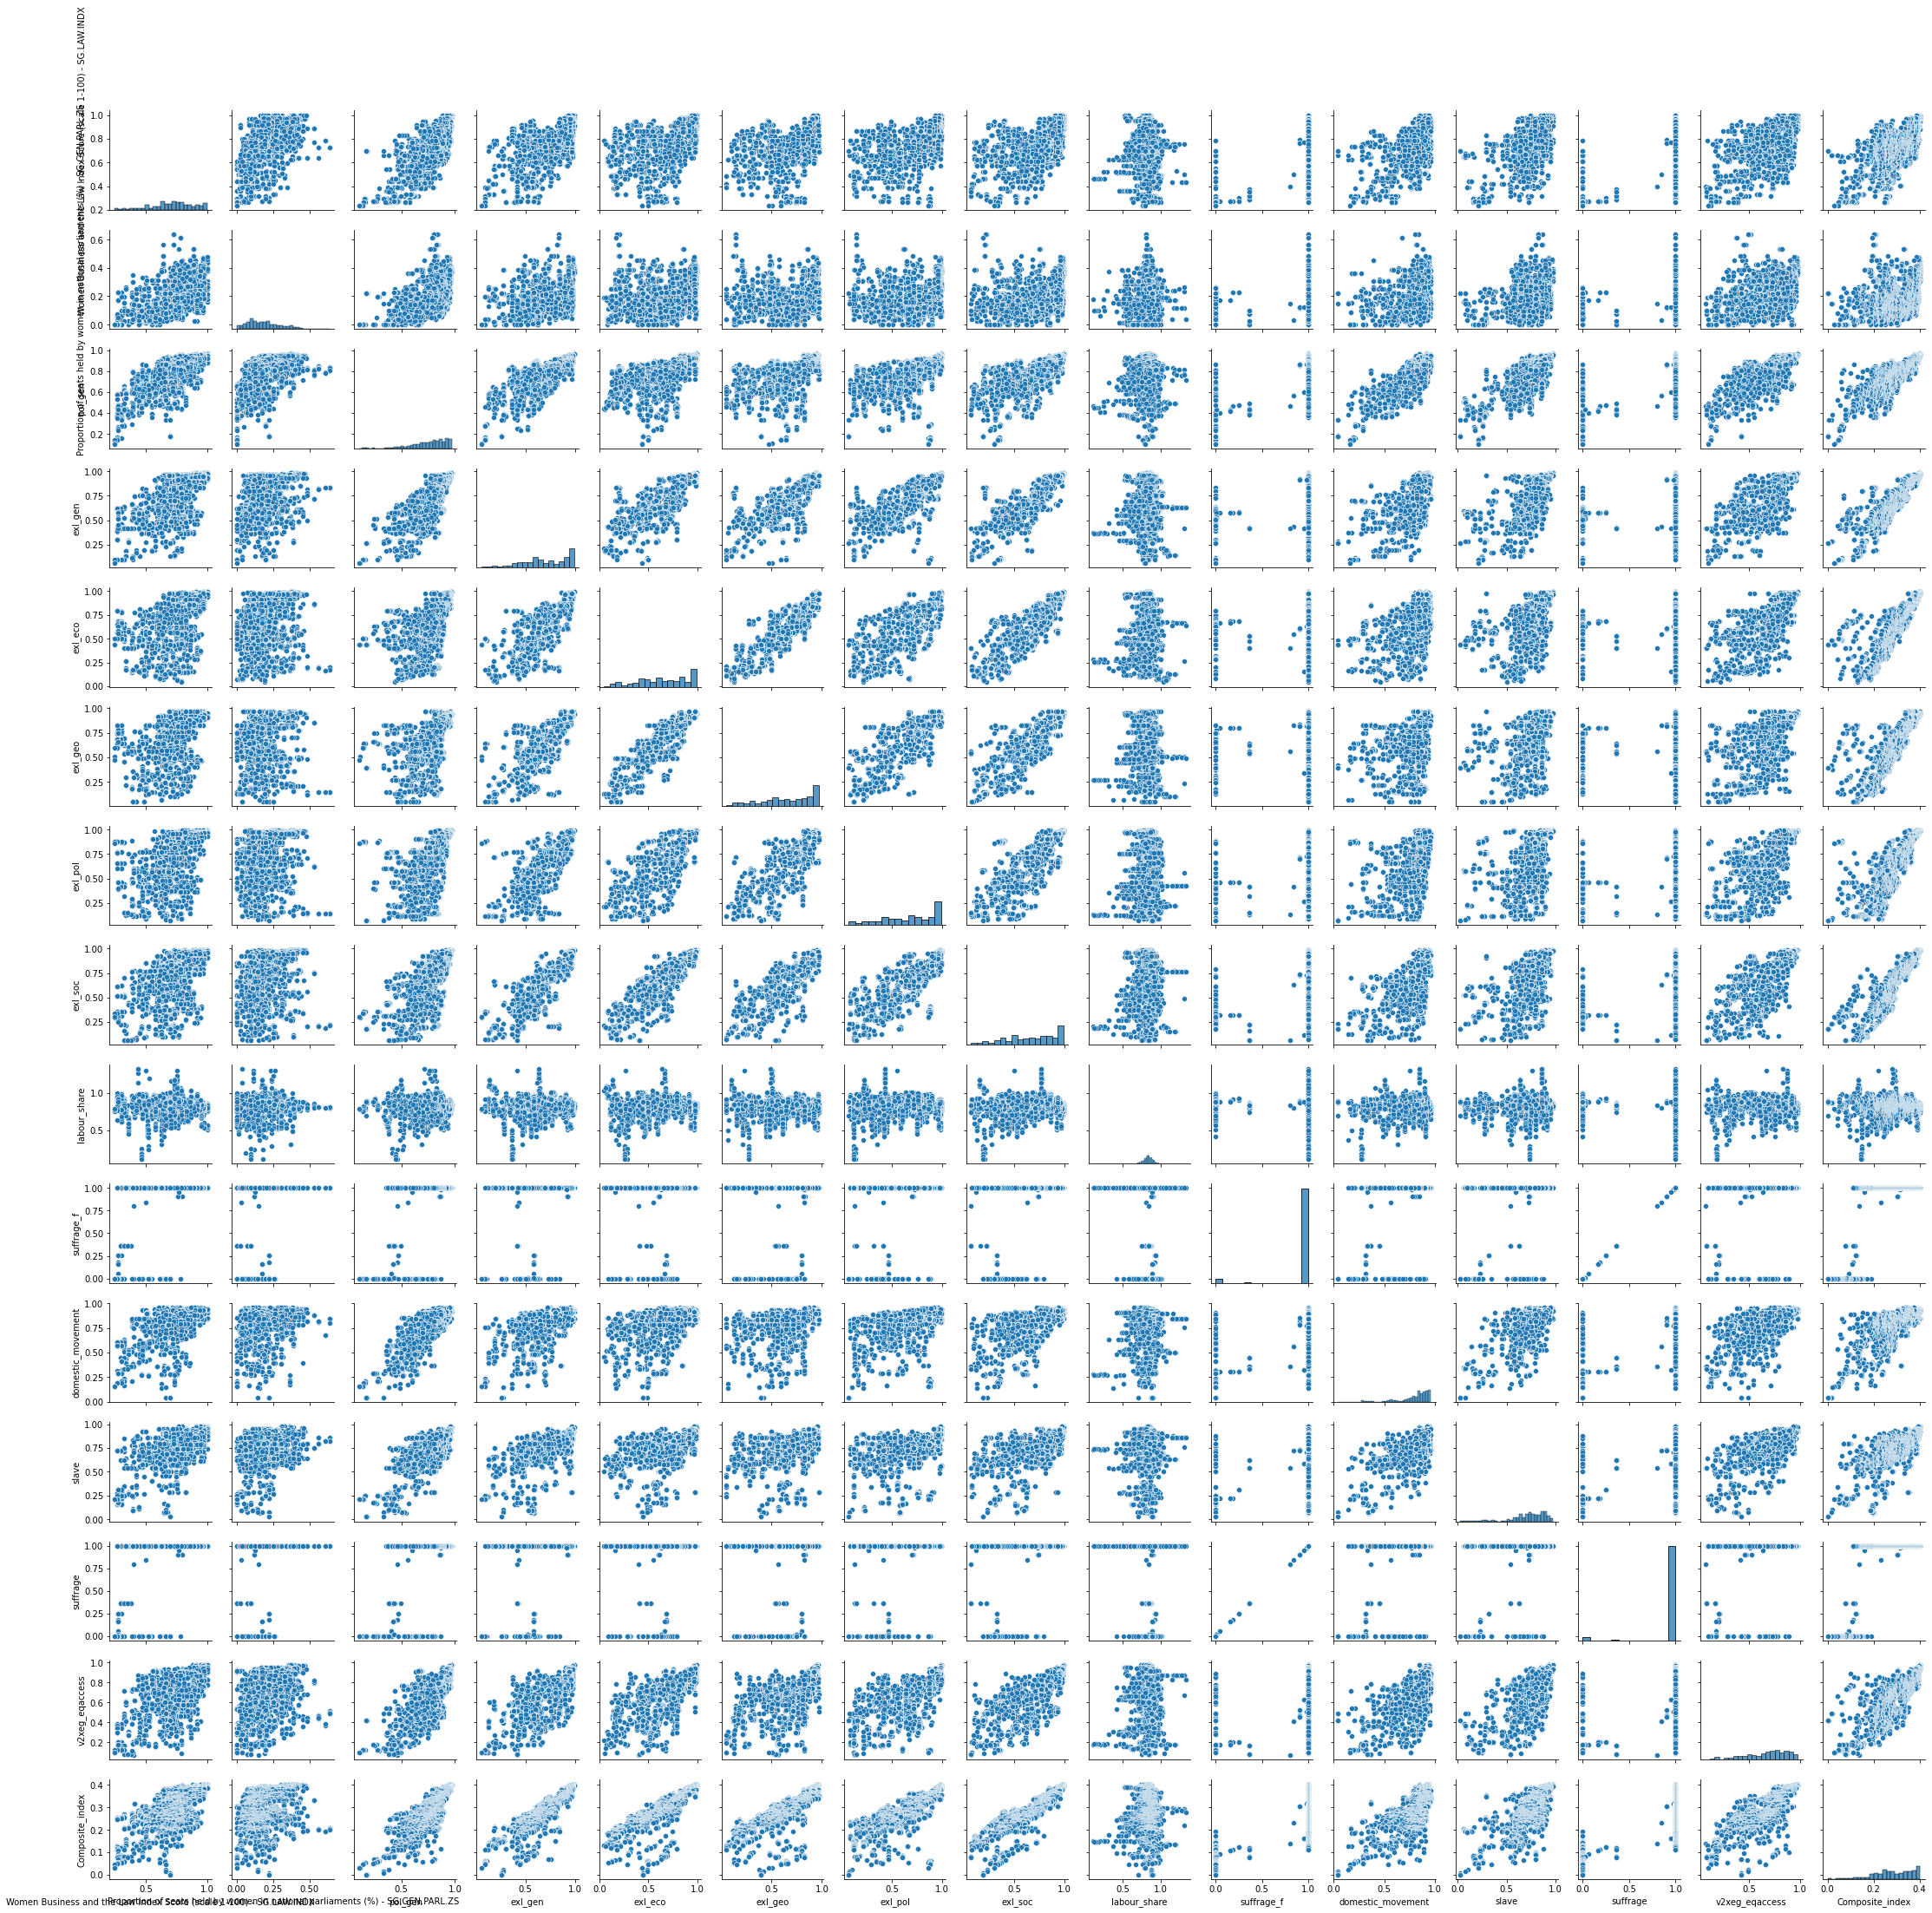

In [ ]:
#plot pairpots
sns.pairplot(final_index[[
       'Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX',
       'Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS',
       'pol_gen', 'exl_gen', 'exl_eco', 'exl_geo', 'exl_pol', 'exl_soc',
       'labour_share', 'suffrage_f', 'domestic_movement', 'slave', 'suffrage',
       'v2xeg_eqaccess', 'Composite_index']])

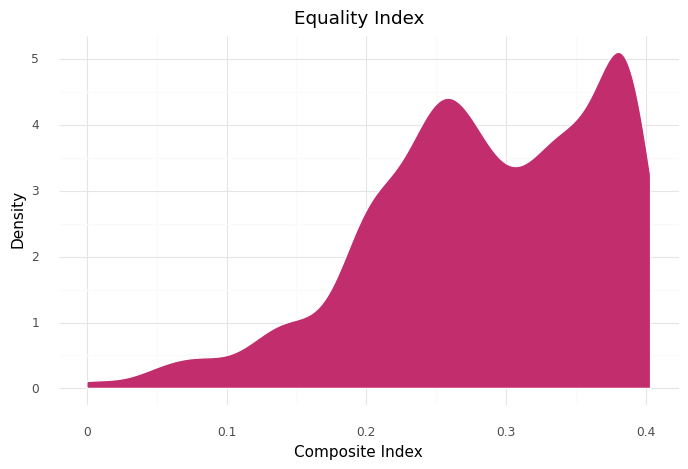

<ggplot: (8787306362417)>

In [ ]:
# Plot distribution
from plotnine import ggplot, aes, geom_density, options,labs, xlab,ylab, theme_minimal
options.figure_size = (8, 4.8)
composite_index_distribution = (
    ggplot(data = final_index)+
    geom_density(aes(x = 'Composite_index'),
                 color = 'white',
                 fill = '#c22d6d')+
    labs(title = 'Equality Index')+
    xlab('Composite Index')+
    ylab('Density')+
    theme_minimal()
)

composite_index_distribution

**UK Trend**

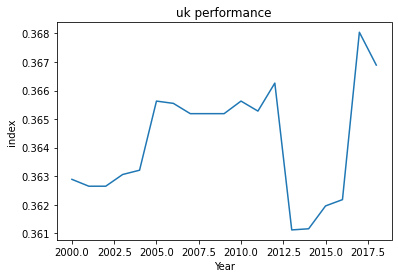

In [ ]:
uk=final_index[final_index['Country Code']=='GBR'].sort_values('Year')

plt.plot(uk.Year,uk.Composite_index)
plt.title('uk performance')
plt.xlabel('Year')
plt.ylabel('index')
plt.show()

**Spain Trend**

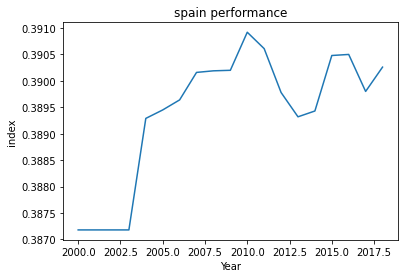

In [ ]:
spain=final_index[final_index['Country Code']=='ESP'].sort_values('Year')

plt.plot(spain.Year,spain.Composite_index)
plt.title('spain performance')
plt.xlabel('Year')
plt.ylabel('index')
plt.show()

##### Look at which countries have the largest percentage difference in min max index score

In [ ]:
#calculate percentage difference in min max index score
pg=final_index.groupby('Country Name')['Composite_index'].agg(['min','max'])
pg.columns

Index(['min', 'max'], dtype='object')

In [ ]:
#find top 20 countries in terms of percenrage growth in index score
pg['pg']=((pg['max']-pg['min'])/pg['min'])*100
pg.sort_values('pg',ascending=False).head(20)

min      max          pg
Country Name                                      
Liberia               0.04482  0.24705  451.204819
Madagascar            0.05724  0.21954  283.542977
Nepal                 0.07989  0.29020  263.249468
Haiti                 0.05305  0.18663  251.800189
Rwanda                0.06784  0.20842  207.222877
Bangladesh            0.06324  0.19332  205.692600
Burundi               0.08689  0.21877  151.778110
United Arab Emirates  0.04990  0.12459  149.679359
Guinea-Bissau         0.09651  0.23695  145.518599
Bhutan                0.14175  0.33605  137.072310
Kuwait                0.11468  0.25392  121.416114
Comoros               0.11256  0.24379  116.586709
Jordan                0.12663  0.26840  111.956093
Saudi Arabia          0.02928  0.06104  108.469945
Lebanon               0.12228  0.25206  106.133464
Thailand              0.14820  0.28529   92.503374
Georgia               0.19117  0.35137   83.799759
Bahrain               0.07738  0.13656   76.479711
Lesotho               0.17333  0.30166   74.037962
Angola                0.12505  0.20169   61.287485

**Liberia**

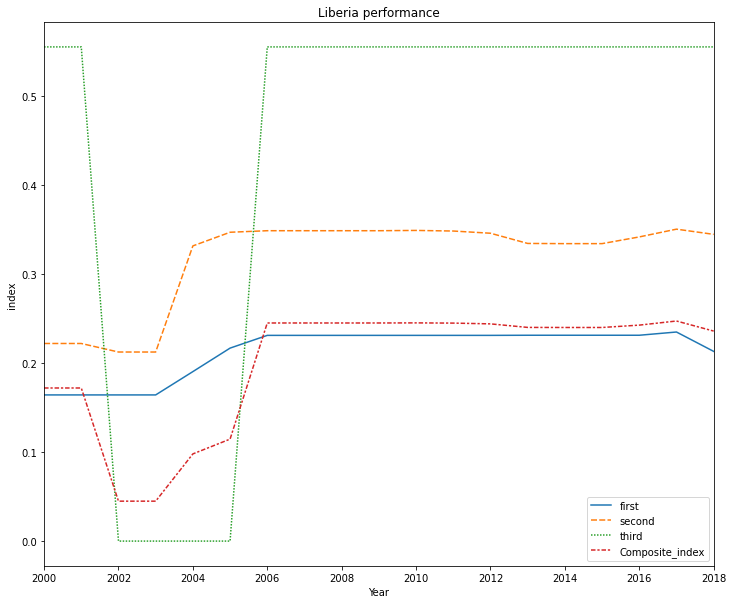

In [ ]:
#plot the intermediates
cols=[ 'Year', 'first','second','third','Composite_index']
Liberia=final_index[final_index['Country Name']=='Liberia'].sort_values('Year')
Liberia=Liberia[cols].set_index('Year')
fig, ax = plt.subplots(figsize=(12, 10))
sns.lineplot(data=Liberia)
plt.title('Liberia performance')
plt.xlabel('Year')
plt.ylabel('index')
plt.xlim(2000, 2018)
plt.show()

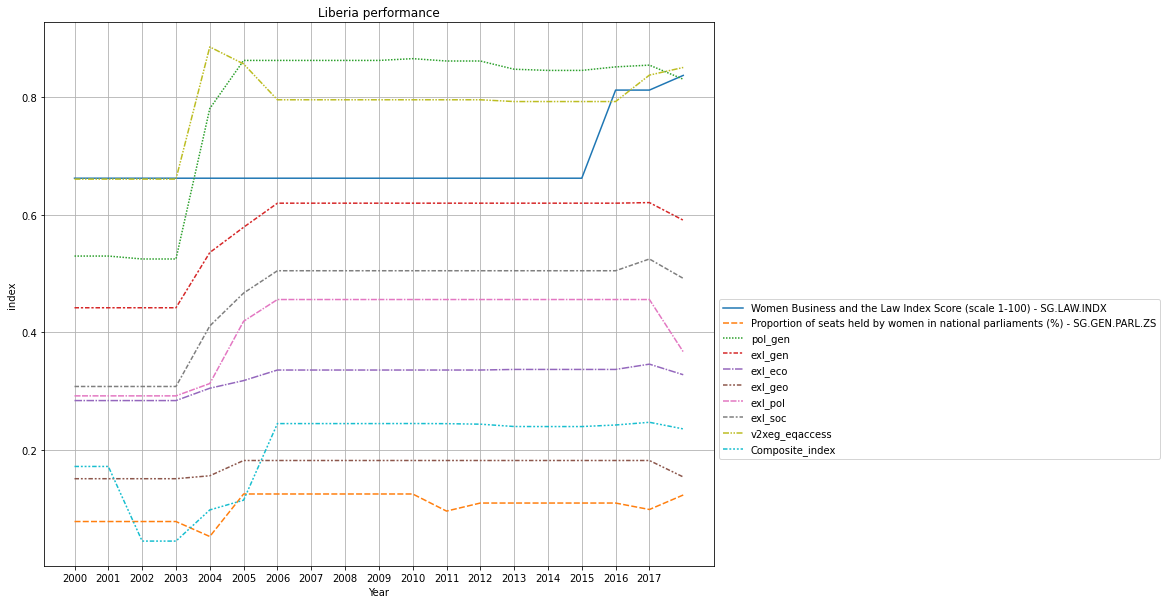

In [ ]:
#plot underlying indicators of the second intermediate
cols=[ 'Year',
       'Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX',
       'Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS',
       'pol_gen', 'exl_gen', 'exl_eco', 'exl_geo', 'exl_pol', 'exl_soc',
       'v2xeg_eqaccess', 'Composite_index']
       Liberia=final_index[final_index['Country Name']=='Liberia'].sort_values('Year')
Liberia=Liberia[cols].set_index('Year')
fig, ax = plt.subplots(figsize=(12, 10))
sns.lineplot(data=Liberia)
plt.title('Liberia performance')
plt.xlabel('Year')
plt.ylabel('index')
x_ticks = np.arange(2000,2018, 1)
plt.xticks(x_ticks)
plt.grid()
ax.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
Liberia

Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX  ...  Composite_index
Year                                                                      ...                 
2000                                                              0.6625  ...          0.17186
2001                                                              0.6625  ...          0.17186
2002                                                              0.6625  ...          0.04482
2003                                                              0.6625  ...          0.04482
2004                                                              0.6625  ...          0.09787
2005                                                              0.6625  ...          0.11448
2006                                                              0.6625  ...          0.24483
2007                                                              0.6625  ...          0.24483
2008                                                              0.6625  ...          0.24483
2009                                                              0.6625  ...          0.24483
2010                                                              0.6625  ...          0.24494
2011                                                              0.6625  ...          0.24470
2012                                                              0.6625  ...          0.24383
2013                                                              0.6625  ...          0.23986
2014                                                              0.6625  ...          0.23978
2015                                                              0.6625  ...          0.23978
2016                                                              0.8125  ...          0.24243
2017                                                              0.8125  ...          0.24705
2018                                                              0.8375  ...          0.23575

[19 rows x 10 columns]

**Madagascar**

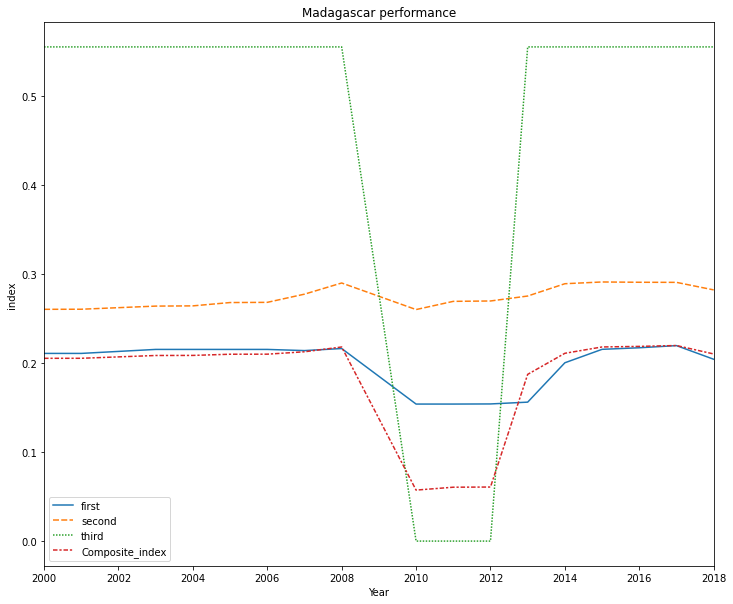

In [ ]:
#plot intermediates
cols=[ 'Year','first', 'second', 'third', 'Composite_index']
Madagascar=final_index[final_index['Country Name']=='Madagascar'].sort_values('Year')
Madagascar=Madagascar[cols].set_index('Year')
fig, ax = plt.subplots(figsize=(12, 10))
sns.lineplot(data=Madagascar)
plt.title('Madagascar performance')
plt.xlabel('Year')
plt.ylabel('index')
plt.xlim(2000, 2018)
plt.show()

In [ ]:
Madagascar

first    second     third  Composite_index
Year                                               
2000  0.210678  0.260174  0.554733          0.20517
2001  0.210678  0.260266  0.554733          0.20520
2003  0.215158  0.263778  0.554733          0.20834
2004  0.215158  0.264043  0.554733          0.20843
2005  0.215158  0.267777  0.554733          0.20975
2006  0.215158  0.267993  0.554733          0.20982
2007  0.213846  0.277186  0.554733          0.21250
2008  0.216155  0.289724  0.554733          0.21790
2010  0.153820  0.259904  0.000000          0.05724
2011  0.153820  0.269109  0.000000          0.06048
2012  0.153954  0.269528  0.000000          0.06068
2013  0.155972  0.275088  0.554733          0.18716
2014  0.200174  0.288906  0.554733          0.21081
2015  0.215261  0.290863  0.554733          0.21792
2016  0.217013  0.290538  0.554733          0.21855
2017  0.219428  0.290429  0.554733          0.21954
2018  0.204111  0.281977  0.554733          0.21005

#### Plot the contribution of intermediates to the index

In [ ]:
for_con=final_index.copy()

In [ ]:
#multiply the intermediates with the prop of variance explained
for_con['first']=(0.090731	*for_con['exl_gen'] + 0.134309	*for_con['exl_eco'] + 0.135653*for_con['exl_geo'] + 0.100612 *for_con['exl_pol']+ 0.116787*for_con['exl_soc'])*0.425101
#second intermediate
for_con['second']=(0.045894*for_con['Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX'] + 0.008458	*for_con['Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS']+ 0.108289*for_con['pol_gen'] + 0.000148*for_con['labour_share']+ 0.099185 *for_con['domestic_movement']+ 0.096307*for_con['slave']+ 	0.058116*for_con['v2xeg_eqaccess'])*0.351974                       	
#third intermediate
for_con['third']= (0.277360*for_con['suffrage_f']+ 0.277373*for_con['suffrage'])*0.222925

top 50 countries in 2018

In [ ]:
# Redefine the data
df_index_reverse=for_con[for_con.Year==2018].head(50).sort_values(by = 'Rank', ascending = False).reset_index(drop = True)
facs=['first','second','third']
df_contribution = pd.melt(frame = df_index_reverse,
                          id_vars = ['Country Name','Year'],
                          value_vars = facs,
                          var_name = 'Factor',
                          value_name = 'Factor Value')
df_contribution

Country Name  Year Factor  Factor Value
0         Bhutan  2018  first      0.201033
1        Romania  2018  first      0.194387
2          Ghana  2018  first      0.196800
3         Israel  2018  first      0.198714
4        Armenia  2018  first      0.193530
..           ...   ...    ...           ...
145      Finland  2018  third      0.123664
146       Sweden  2018  third      0.123664
147      Germany  2018  third      0.123664
148       Norway  2018  third      0.123664
149      Denmark  2018  third      0.123664

[150 rows x 4 columns]

In [ ]:
from plotnine import geom_bar, scale_x_discrete, coord_flip, options, ggplot,aes,labs, xlab, ylab, theme_minimal
options.figure_size = (9, 20)
contribution_factors_composite_index = (
    ggplot(data = df_contribution)+
    geom_bar(aes(x = 'Country Name',
                 y = 'Factor Value',
                 fill = 'Factor'),
             width = 0.75,
             position = 'stack',
             stat = 'identity')+
    scale_x_discrete(limits = df_index_reverse['Country Name'].tolist())+
    labs(title = 'Inequality Index by Country')+
    xlab('Country')+
    ylab('Composite Index')+
    coord_flip()+
    theme_minimal()
)
# Display the viz
contribution_factors_composite_index


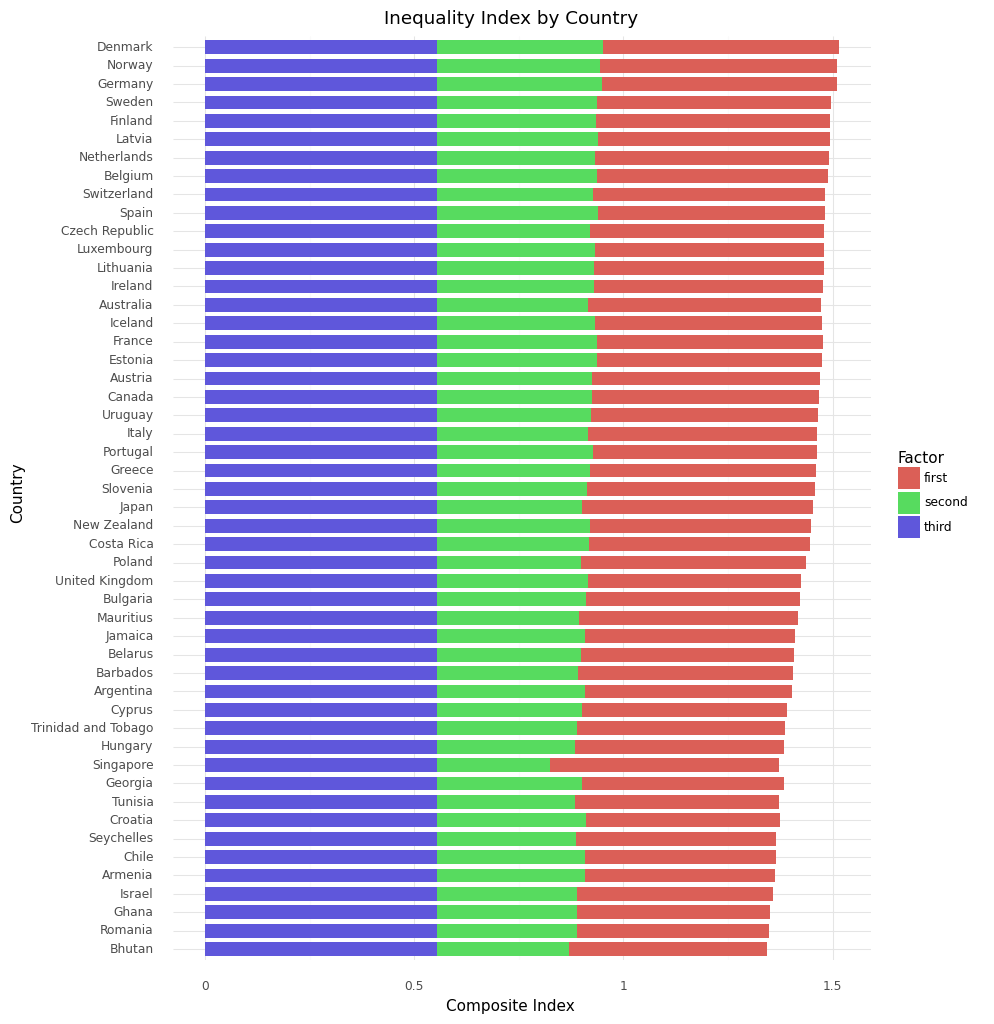

#### Bottom 50 countries in 2018

In [ ]:
# Redefine the data
df_index_reverse=for_con[for_con.Year==2018].tail(10).sort_values(by = 'Rank', ascending = False).reset_index(drop = True)
facs=['first','second','third']
df_contribution = pd.melt(frame = df_index_reverse,
                          id_vars = ['Country Name','Year'],
                          value_vars = facs,
                          var_name = 'Factor',
                          value_name = 'Factor Value')
df_contribution


Country Name  Year  Factor  Factor Value
0           Saudi Arabia  2018   first      0.124674
1                  Qatar  2018   first      0.142512
2             Mauritania  2018   first      0.026615
3   United Arab Emirates  2018   first      0.143773
4             Tajikistan  2018   first      0.038151
5                Bahrain  2018   first      0.080282
6                   Iraq  2018   first      0.039036
7      Equatorial Guinea  2018   first      0.060488
8                   Chad  2018   first      0.052729
9             Bangladesh  2018   first      0.052442
10          Saudi Arabia  2018  second      0.035998
11                 Qatar  2018  second      0.040765
12            Mauritania  2018  second      0.071139
13  United Arab Emirates  2018  second      0.049284
14            Tajikistan  2018  second      0.067725
15               Bahrain  2018  second      0.056982
16                  Iraq  2018  second      0.074086
17     Equatorial Guinea  2018  second      0.064733
18                  Chad  2018  second      0.076148
19            Bangladesh  2018  second      0.086908
20          Saudi Arabia  2018   third      0.000000
21                 Qatar  2018   third      0.000000
22            Mauritania  2018   third      0.123664
23  United Arab Emirates  2018   third      0.031163
24            Tajikistan  2018   third      0.123664
25               Bahrain  2018   third      0.098931
26                  Iraq  2018   third      0.123664
27     Equatorial Guinea  2018   third      0.123664
28                  Chad  2018   third      0.123664
29            Bangladesh  2018   third      0.123664

In [ ]:
from plotnine import geom_bar, scale_x_discrete, coord_flip, options, ggplot,aes,labs, xlab, ylab, theme_minimal
options.figure_size = (9, 20)
contribution_factors_composite_index = (
    ggplot(data = df_contribution)+
    geom_bar(aes(x = 'Country Name',
                 y = 'Factor Value',
                 fill = 'Factor'),
             width = 0.75,
             position = 'stack',
             stat = 'identity')+
    scale_x_discrete(limits = df_index_reverse['Country Name'].tolist())+
    labs(title = 'Inequality Index by Country')+
    xlab('Country')+
    ylab('Composite Index')+
    coord_flip()+
    theme_minimal()
)
# Display the viz
contribution_factors_composite_index


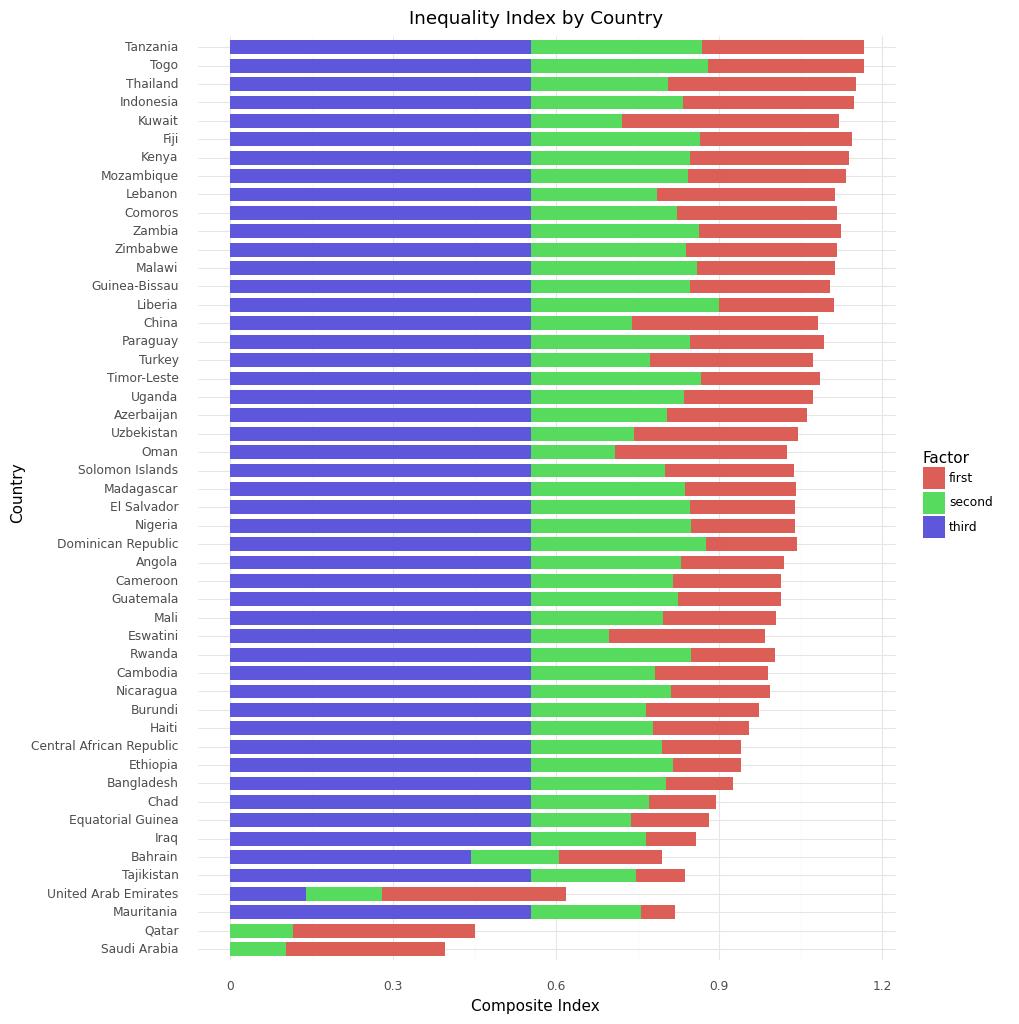